### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- [Modeling](./03_modeling.ipynb)
- Experiments (this notebook)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- TODO etc.

In [88]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models for FL NLP
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# additional models for GA feature importance testing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, recall_score, f1_score, precision_score, confusion_matrix

# global random seed
np.random.seed(42)

In [89]:
# same function used in modeling notebook for evaluation
# Dataframe to collect results
model_trials_df = pd.DataFrame(columns=['dataset_name', 'model_used', 'model_params', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

def model_trials(dataset_name, X, y, model, model_id, scale_first = False, gs_params = None):
    '''
    Takes in dataset information and a (non-neural-net) model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): non-neural-net model to fit
    - model_id (string): friendly name for model to include in results
    - scale_first (boolean): indicates whether the feature set X should be scaled before fitting
    - gs_params (dict): parameters for a GridSearch - if None, model will be fit without GridSearching

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    '''Scale if needed'''
    if (scale_first):
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    if (gs_params):
        gs = GridSearchCV(model, gs_params)
        gs.fit(X_train, y_train)
        model = gs.best_estimator_
        model_params = gs.best_params_
    else:
        model.fit(X_train, y_train)
        model_params = model.get_params()

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

In [90]:
# same function used in modeling notebook for evaluation
# neural net version
def model_trials_nn(dataset_name, X, y, model, model_id, epochs = 10, batch_size = 32, callbacks = None):
    '''
    Takes in dataset information and a neural network model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion. NOTE: assumes model's
    output layer uses the sigmoid activation function (i.e., binary classification) and was compiled with 'accuracy' among its metrics.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): neural network model to fit
    - model_id (string): friendly name for model to include in results
    - epochs (int): number of neural network epochs to run
    - batch_size (int): size of neural network batch
    - callbacks (list): list of callbacks to invoke while fitting, e.g., EarlyStopping

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

    '''Always scale for neural nets!'''
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    res = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size, callbacks = callbacks, verbose = 0)
    model_params = {'epochs': epochs, 'batch_size': batch_size} # all we'll capture for these - there are too many weights to be useful!
        
    train_score = res.history['accuracy'][-1]
    test_score = res.history['val_accuracy'][-1]

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    '''Assumes a 0.5 probability threshold'''
    preds = [1 if x >= 0.5 else 0 for x in model.predict(X_test)[:, 0]]
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'viridis', values_format = 'd');
    else: 
        return ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'magma', values_format = 'd');

**Model 2: Criminal history feature set - Florida - NLP charge modeling**

- We're going to try vectorizing each person's list of charges and incorporating some NLP into our production model.
- We'll use TFIDF vectorization, and before merging the NLP columns into our production model, we'll use a GridSearch with a simple LogisticRegression to
determine the best parameters to use for TFIDF.

In [91]:
fl = pd.read_csv('../data/FL/FL_final.csv')

# drop all non-model columns - keeping agg_charges this time!
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

Dataset: FL
Model ID: TFIDF + Logreg
Model Params: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Training Score: 0.7857
Testing Score: 0.7595 

Accuracy: 0.7595
Specificity: 0.8631
Precision: 0.7389
Recall: 0.5993
F1 Score: 0.6618 

Best accuracy rate confusion matrix:


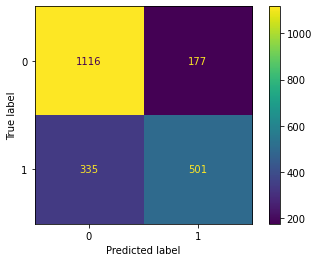

In [92]:
# define X and y, train-test split
nlp = fl[['agg_charges', 'recidivism']].dropna()
X = nlp['agg_charges']
y = nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Pipeline with logreg
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

model_trials('FL', X, y, pipe, 'TFIDF + Logreg', gs_params = pipe_params);

In [93]:
# what were our best parameters?
model_trials_df[model_trials_df['dataset_name'] == 'FL']['model_params'].values

array([{'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}],
      dtype=object)

In [94]:
# now we can apply our optimal vectorization
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 3000, min_df = 2, ngram_range = (1, 2))
nlpcols = tfidf.fit_transform(fl['agg_charges'])

In [95]:
# and add the vectorized columns to our main dataframe
fl_nlp = pd.concat([fl, pd.DataFrame(nlpcols.todense(), columns = tfidf.get_feature_names_out())], axis = 1)

In [96]:
# define our final X and y
X = fl_nlp.drop(columns = ['recidivism', 'agg_charges'])
y = fl_nlp['recidivism']


In [97]:
# need to check our neural net input size
X.shape

(10645, 3034)

67/67 [==============================] - 0s 1ms/step
Dataset: FL
Model ID: NLP FNN
Model Params: {'epochs': 100, 'batch_size': 256}
Training Score: 0.9587
Testing Score: 0.7642 

Accuracy: 0.7642
Specificity: 0.8252
Precision: 0.7125
Recall: 0.6699
F1 Score: 0.6905 

Best accuracy rate confusion matrix:


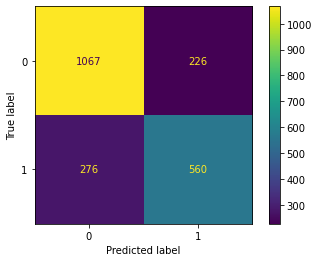

In [98]:
# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 128, activation = 'relu', input_shape = (3034, ),
    kernel_regularizer = l2(0.01)))
model.add(Dense(units = 64, activation = 'relu', kernel_regularizer = l2(0.01)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['accuracy'])

# Fit & evaluate
model_trials_nn('FL', X, y, model, 'NLP FNN', epochs = 100, batch_size = 256, callbacks = [es])

CONCLUSIONS
- Looks like adding the NLP columns to the production model causes pretty major overfitting - possibly the result of trying such high-dimensional data with a neural network.
- We won't use the NLP columns. Worthwhile experiment though!
- We will capture the "top 10" words according to TFIDF as a point of interest for presentation.

In [100]:
# top 10 words
X[[col for col in X if len(col.split()) == 1]].sum().sort_values(ascending = False)[:10]

age_at_first_release              333820.0
age_at_first_incarceration        329222.0
age_at_first_arrest               298463.0
total_charge_count                 90371.0
total_misdemeanor_charge_count     39039.0
total_felony_charge_count          35335.0
num_incarcerations                 26273.0
charge_degree_count_F3             25634.0
charge_degree_count_M1             24124.0
charge_degree_count_INF            15997.0
dtype: float64

In [101]:
# top 10 bigrams
X[[col for col in X if len(col.split()) == 2]].sum().sort_values(ascending = False)[:10]

possession of        311.686791
fail to              298.856174
license suspended    297.156443
grand theft          290.499600
in the               262.919970
theft in             259.937066
3rd degree           258.302116
the 3rd              258.301441
or less              253.247045
possess cannabis     252.835117
dtype: float64

---
**Model 3: Behavioral feature set - Georgia - focus on important features**

- We're going build a model using only the most important features identified during the model trials, in the hopes reducing some of the noise and improving our accuracy.

In [69]:
# Reading in necessary files
ga_dummy = pd.read_csv('../data/GA/georgia_dummy.csv')
feats = pd.read_csv('../data/GA/important_feats.csv')

In [70]:
# Merging dataframes to include only the important features and target column

important_feats = feats.loc[(feats['coef'] > 1.15) | (feats['coef'] < 0.85)]

important_cols = [col for col in important_feats['feature']]

ga_exper = ga_dummy[important_cols]
ga_exper = ga_exper.join(ga_dummy['recidivism_within_3years'])
ga_exper

,gang_affiliated,age_at_release_18-22,age_at_release_23-27,gender_male,condition_mh_sa,drugtests_thc_positive,violations_instruction,violations_electronicmonitoring,prison_years_more than 3 years,education_level_less than hs diploma,age_at_release_38-42,education_level_at least some college,prison_years_greater than 2 to 3 years,age_at_release_43-47,age_at_release_48 or older,percent_days_employed,recidivism_within_3years
0,0,0,0,1,1,0.000000,0,0,1,0,0,1,0,1,0,0.488562,0
1,0,0,0,1,0,0.000000,1,0,1,1,0,0,0,0,0,0.425234,1
2,0,0,0,1,1,0.333333,1,0,0,0,0,1,0,0,1,0.000000,1
3,0,0,0,1,1,0.000000,0,0,0,1,1,0,0,0,0,1.000000,0
4,0,0,0,1,1,0.000000,0,0,0,1,0,0,0,0,0,0.203562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24421,0,0,1,1,0,0.000000,0,0,1,0,0,1,0,0,0,0.189507,1
24422,0,0,0,1,0,0.000000,0,0,1,0,1,1,0,0,0,0.757098,1
24423,0,0,0,1,0,0.000000,0,1,1,0,0,1,0,0,0,0.711138,1
24424,0,0,0,0,0,0.000000,0,0,1,0,0,1,0,0,0,0.000000,0


In [71]:
# setup X and y
X = ga_exper.drop(columns='recidivism_within_3years')
y = ga_exper['recidivism_within_3years']

Dataset: GA
Model ID: Gradient Boosting
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.696
Testing Score: 0.6762 

Accuracy: 0.6762
Specificity: 0.535
Precision: 0.7104
Recall: 0.7718
F1 Score: 0.7398 

Best accuracy rate confusion matrix:


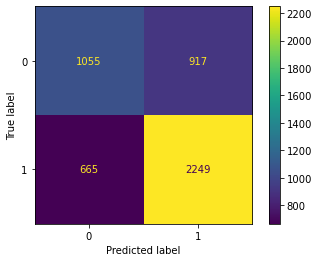

In [72]:
gb = GradientBoostingClassifier()

model_trials('GA', X, y, gb, 'Gradient Boosting');

Dataset: GA
Model ID: Logistic Regression
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.6802
Testing Score: 0.6701 

Accuracy: 0.6701
Specificity: 0.5117
Precision: 0.7017
Recall: 0.7773
F1 Score: 0.7375 

Best accuracy rate confusion matrix:


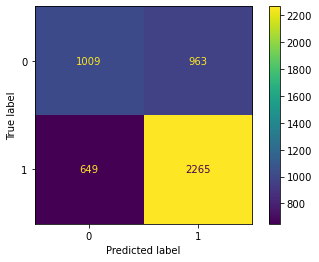

In [73]:
lr = LogisticRegression()

model_trials('GA', X, y, lr, 'Logistic Regression');

Dataset: GA
Model ID: KNN
Model Params: {'memory': None, 'steps': [('ss', StandardScaler()), ('knn', KNeighborsClassifier())], 'verbose': False, 'ss': StandardScaler(), 'knn': KNeighborsClassifier(), 'ss__copy': True, 'ss__with_mean': True, 'ss__with_std': True, 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Training Score: 0.7275
Testing Score: 0.6339 

Accuracy: 0.6339
Specificity: 0.5137
Precision: 0.6849
Recall: 0.7152
F1 Score: 0.6997 

Best accuracy rate confusion matrix:


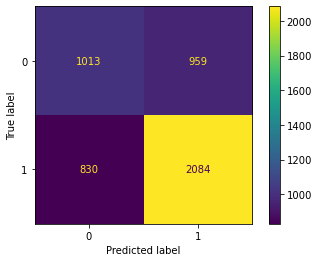

In [75]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_trials('GA', X, y, knn, 'KNN');

Random Forest
Training Score: 0.8805
Testing Score: 0.6279 

Accuracy: 0.6279
Specificity: 0.4746
Precision: 0.673
Recall: 0.7316
F1 Score: 0.7011 

Best accuracy rate confusion matrix:


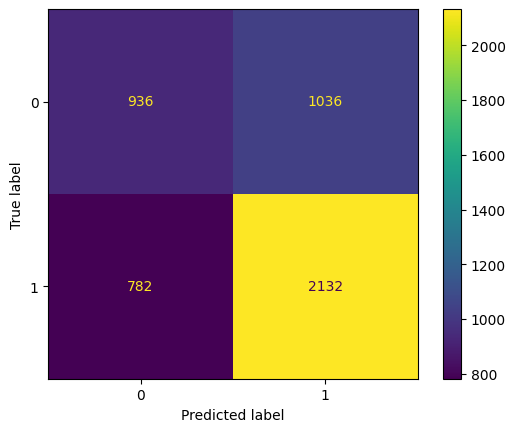

In [ ]:
rf = RandomForestClassifier()

model_trials('GA', X, y, rf, 'Random Forest');

Ada Boost
Training Score: 0.6885
Testing Score: 0.6758 

Accuracy: 0.6758
Specificity: 0.5446
Precision: 0.7127
Recall: 0.7646
F1 Score: 0.7377 

Best accuracy rate confusion matrix:


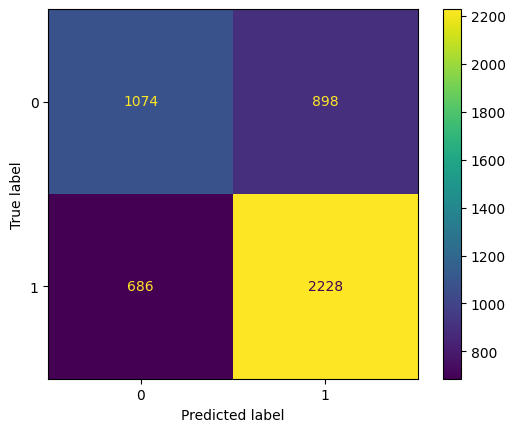

In [ ]:
ada = AdaBoostClassifier(random_state=42)

model_expers(ada, 'Ada Boost')

MultinomialNB
Training Score: 0.6536
Testing Score: 0.651 

Accuracy: 0.651
Specificity: 0.4143
Precision: 0.6718
Recall: 0.8113
F1 Score: 0.735 

Best accuracy rate confusion matrix:


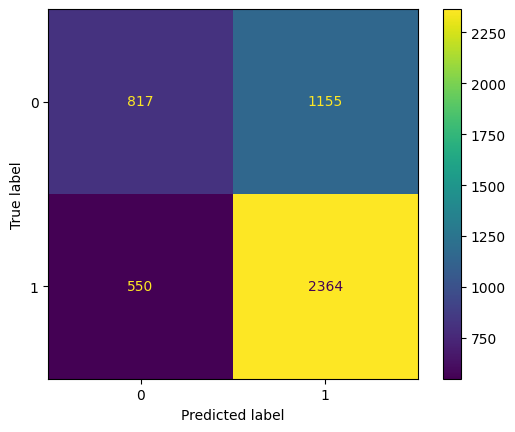

In [ ]:
mnb = MultinomialNB()

model_expers(mnb, 'MultinomialNB')

BaggingClassifier
Training Score: 0.8664
Testing Score: 0.623 

Accuracy: 0.623
Specificity: 0.5081
Precision: 0.678
Recall: 0.7008
F1 Score: 0.6892 

Best accuracy rate confusion matrix:


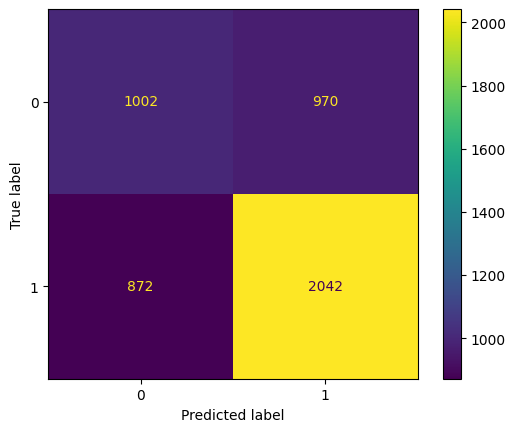

In [ ]:
bag = BaggingClassifier()

model_expers(bag, 'BaggingClassifier')

Decision Tree
Training Score: 0.8805
Testing Score: 0.6017 

Accuracy: 0.6017
Specificity: 0.5025
Precision: 0.6652
Recall: 0.6688
F1 Score: 0.667 

Best accuracy rate confusion matrix:


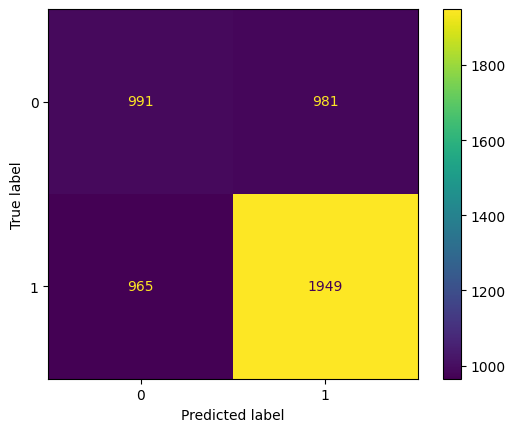

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)

model_expers(dtree, 'Decision Tree')

In [ ]:
model_experiments_df

,model_used,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
0,Gradient Boosting,0.696008,0.676218,0.676218,0.534990,0.710360,0.771791,0.739803,1055,917,665,2249
1,Logistic Regression,0.680194,0.670078,0.670078,0.511663,0.701673,0.777282,0.737545,1009,963,649,2265
2,KNN,0.728915,0.631805,0.631805,0.512170,0.683449,0.712766,0.697799,1010,962,837,2077
3,Random Forest,0.880502,0.627916,0.627916,0.474645,0.672980,0.731640,0.701085,936,1036,782,2132
4,Ada Boost,0.688485,0.675808,0.675808,0.544625,0.712732,0.764585,0.737748,1074,898,686,2228
5,MultinomialNB,0.653634,0.651044,0.651044,0.414300,0.671782,0.811256,0.734960,817,1155,550,2364
6,BaggingClassifier,0.866428,0.623005,0.623005,0.508114,0.677955,0.700755,0.689166,1002,970,872,2042
7,Decision Tree,0.880502,0.601719,0.601719,0.502535,0.665188,0.668840,0.667009,991,981,965,1949


- All models aside from MNB scored worse on accuracy

**FINAL NOTES**
- TODO etc.
- The last notebook in the series is [Results and Recommendations](./04_results.ipynb).